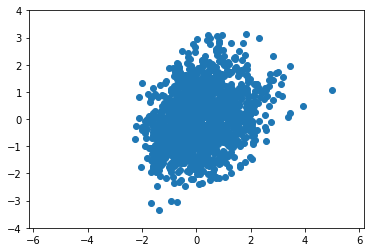

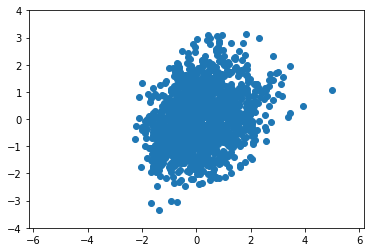

In [2]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import DataProvider as DP
import numpy as np
from PIL import Image

from IPython import display

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def imshow(img):
    img = img.cpu().numpy()
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    
def imsave(img, path):
    img = vutils.make_grid(img).cpu()
    img = img.numpy()
    img = np.transpose(img, [1,2,0])
    result = Image.fromarray((img * 255).astype(np.uint8))
    result.save(path)
    

# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset', required=True, help='cifar10 | lsun | imagenet | folder | lfw ')
# parser.add_argument('--dataroot', required=True, help='path to dataset')
# parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
# parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
# parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
# parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
# parser.add_argument('--ngf', type=int, default=64)
# parser.add_argument('--ndf', type=int, default=64)
# parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
# parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
# parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
# parser.add_argument('--cuda'  , action='store_true', help='enables cuda')
# parser.add_argument('--ngpu'  , type=int, default=1, help='number of GPUs to use')
# parser.add_argument('--netDec', default='', help="path to netDec (to continue training)")
# parser.add_argument('--netD', default='', help="path to netD (to continue training)")
# parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')


def opt(): 1
opt.adam=False
opt.batchSize=128 
opt.beta1=0.5

opt.cuda=True

opt.experiment=None
opt.imageSize=64
opt.lr=0.0002

opt.ndf=64
opt.netD=''
opt.netDec=''
opt.ngf=64
opt.ngpu=1
opt.niter=250
opt.noBN=False
opt.nz=32
opt.workers=2
opt.outf = 'AAE'

print(opt)

try:
    os.makedirs(opt.outf)
except OSError:
    pass
opt.manualSeed = random.randint(1, 10000) # fix seed
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

image_dir = '/root/images/2016_11_08_Nuc_Cell_Seg_8_cell_lines_V22/processed_aligned/2D/'

opts = {}
opts['out_size'] = [64, 64]
opts['verbose'] = True

data_path = './data_64x64.pyt'

if os.path.exists(data_path):
    dp = torch.load(data_path)
else:
    dp = DP.DataProvider(image_dir, opts)
    torch.save(dp, data_path)

ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
nc = 3

# custom weights initialization called on netDec and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
           
class _netEnc(nn.Module):
    def __init__(self, ngpu):
        super(_netEnc, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, 64, 4, 2, 1),
            nn.BatchNorm2d(64),            
            nn.PReLU(),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.PReLU(),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.PReLU(),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(512, nz, 4, 1, 0),
            nn.BatchNorm2d(nz)
        )
    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        output = nn.parallel.data_parallel(self.main, input, gpu_ids)
        return output

netEnc = _netEnc(ngpu)
netEnc.apply(weights_init)
print(netEnc)
        
class _netDec(nn.Module):
    def __init__(self, ngpu):
        super(_netDec, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, 512, 4, 1, 0),
            nn.BatchNorm2d(512),
            nn.PReLU(),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.PReLU(),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(128,64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(64, nc, 4, 2, 1),
            nn.BatchNorm2d(nc),            
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        return nn.parallel.data_parallel(self.main, input, gpu_ids)

netDec = _netDec(ngpu)
netDec.apply(weights_init)
if opt.netDec != '':
    netDec.load_state_dict(torch.load(opt.netDec))
print(netDec)        
 

class _netAdv(nn.Module):
    def __init__(self, ngpu):
        super(_netAdv, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(nz, 1024),         
            nn.ReLU(True),
            
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
    def forward(self, input):
        gpu_ids = None
        
        input = input.view(input.size()[0], opt.nz)
        
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        output = nn.parallel.data_parallel(self.main, input, gpu_ids)
        return output

netAdvZ = _netAdv(ngpu)
netAdvZ.apply(weights_init)
print(netAdvZ)

criterion = nn.BCELoss()

input = torch.FloatTensor(opt.batchSize, 3, opt.imageSize, opt.imageSize)
noise = torch.FloatTensor(opt.batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(opt.batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(opt.batchSize)
real_label = 1
fake_label = 0

if opt.cuda:
    netDec.cuda()
    netEnc.cuda()
    netAdvZ.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

input = Variable(input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)

opt.lr = 0.01

# setup optimizer
# optimizerDec = optim.Adam(netDec.parameters(), lr = 0.01, betas = (opt.beta1, 0.999))
# optimizerAdvZ = optim.Adam(netAdvZ.parameters(), lr = 0.01, betas = (opt.beta1, 0.999))
# optimizerEnc = optim.Adam(netEnc.parameters(), lr = 0.01, betas = (opt.beta1, 0.999))

optimizerDec = optim.RMSprop(netDec.parameters(), lr = opt.lr)
optimizerAdvZ = optim.RMSprop(netAdvZ.parameters(), lr = opt.lr)
optimizerEnc = optim.RMSprop(netEnc.parameters(), lr = 0.001)

for epoch in range(opt.niter):
    rand_inds = np.random.permutation(dp.get_n_train())
    data_iter = [rand_inds[i:i+opt.batchSize] for i in range(0, len(rand_inds), opt.batchSize)]
    data_iter = data_iter[1:]
    
    zAll = list()
#     data_iter = iter(dataloader)
    i = 0
    while i < len(data_iter):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real

        
        real_cpu = dp.get_images(data_iter[i], 'train')
        i += 1
        
        batch_size = real_cpu.size(0)

        input = Variable(real_cpu).cuda()
        labelReal = Variable(torch.Tensor(batch_size).fill_(real_label)).cuda()
        labelFake = Variable(torch.Tensor(batch_size).fill_(fake_label)).cuda()

        netEnc.zero_grad()
        netDec.zero_grad()
        
        # Forward through autoencoder
        latent = netEnc(input)
        latent2 = latent.detach()
        
        fake = netDec(latent)
        errEnc = criterion(fake, input)
        
                
        ############################
        # (1) Update AdvLatent network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netAdvZ.zero_grad()
        
        noise.data.resize_(batch_size, nz, 1, 1).normal_(0,1)
        predZReal = netAdvZ(noise)
        errZ_real = criterion(predZReal, labelReal)
        
        predZFake = netAdvZ(latent2)
        errZ_fake = criterion(predZFake, labelFake)
        
        errZ = errZ_real + errZ_fake
        errZ.backward()
        
        optimizerAdvZ.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        # update wrt to output
        predZFake = netAdvZ(latent)
        errAdvZ = criterion(predZFake, labelReal)

        
#         for param in netAdvZ.parameters():
#             param.requires_grad = False
        
#         errEnc.backward(retain_variables=True)
        
# #         errAdvZ.grad.data *= 1E-6
#         errAdvZ.backward() 
    
        err = errEnc + errAdvZ
        err.backward()
        
#         for param in netAdvZ.parameters():
#             param.requires_grad = True
        
        optimizerDec.step()
        optimizerEnc.step()
        
        zAll.append(latent.data)

        print('[%d/%d][%d/%d] errRecon: %.4f errZ: %.4f errMinimax: %.4f'
              % (epoch, opt.niter, i, len(data_iter),
                 errEnc.data[0], errZ.data[0], errAdvZ.data[0]))
    
    optimizerDec.param_groups[0]['lr'] = opt.lr*(0.999**epoch)
    optimizerEnc.param_groups[0]['lr'] = opt.lr*(0.999**epoch)
    optimizerAdvZ.param_groups[0]['lr'] = opt.lr*(0.999**epoch)
         
        
    zAll = torch.cat(zAll,0).cpu().numpy()

    display.clear_output(wait=True)
    
    plt.gca().cla() 
    plt.scatter(zAll[:,0], zAll[:,1])
    plt.axis('equal')    
    plt.axis([-4, 4, -4, 4])

#     plt.xlim([-4, 4]) 
#     plt.ylim([-4, 4])     

    
    display.display(plt.gcf()) 
    
    imsave(real_cpu, '%s/real_samples.png' % opt.outf)
    fake = netDec(fixed_noise)
    
    imsave(fake.data, '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch))

    # do checkpointing
#     torch.save(netDec.state_dict(), '%s/netDec_epoch_%d.pth' % (opt.outf, epoch))
#     torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

    

In [ ]:
torch.Tensor(10).random_(0,10) #works
torch.Tensor(10).random_(0,10).cuda() #works
torch.Tensor(10).cuda().random_(0,10) #does not work

# noise.data.normal_(0,10)

In [3]:
errAdvZ.grad.data


 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]